
# CodeGenie — Milestone 2

**Author:** Piyushmani Tiwari

**Goal:** Implement and compare code generation across five models (DeepSeek-Coder-1.3B, Phi-2-2.7B, Gemma-2B-IT, Stable-Code-3B, Replit-Code-3B). Ready to present to mentor.

---

This notebook follows the uploaded UI reference `Interactive_Notebook_UI (1).ipynb` and the task list in `CodeGenie Milestone2 (1)` and integrates Day 6 & Day 7 materials.


#Section 1: Setup and Installations

In [2]:
# Setup: uncomment the installs below when running in Colab or local environment with internet & GPU.
# !pip install -q transformers accelerate bitsandbytes sentencepiece git+https://github.com/huggingface/transformers.git
# !pip install -q datasets nltk rouge-score
# !pip install -q evaluate

print("Installing required libraries...")
!pip install transformers torch accelerate bitsandbytes pandas huggingface_hub radon ipywidgets matplotlib seaborn -q

# Imports commonly used in the notebook
import os, time, json, math, textwrap
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import notebook_login
import ast
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze

# For evaluation
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except:
    nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

print("\nSetup Complete! ")


Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.8 MB/s eta 0:00:00

Setup Complete! 


#Section 2: Secure Hugging Face Login
Explanation: This section handles authentication, which is required for any "gated" models you may use. Run this cell and enter your Hugging Face access token when prompted.

> Add blockquote



In [3]:
!pip install -q huggingface_hub transformers

from getpass import getpass
from huggingface_hub import login, whoami
import os

#  Enter your token (input hidden)
hf_token = getpass("Enter your Hugging Face Access Token: ").strip()

#  Login and store token for Transformers
login(token=hf_token)
os.environ["HF_TOKEN"] = hf_token  # make token available to all later cells

#  Verify login success
try:
    me = whoami()
    print(f" Logged in as: {me.get('name') or me.get('user')}")
except Exception as e:
    print(" Login check failed:", e)



Enter your Hugging Face Access Token: ··········
 Logged in as: piyushmanitv


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Section 3: Models & Loading Notes

This notebook provides example loading code for the following model IDs (Hugging Face Hub):

- `deepseek-ai/deepseek-coder-1.3b-instruct`
- `microsoft/phi-2-2.7b` (phi-2 family)
- `google/gemma-2b-it`
- `stabilityai/stable-code-3b`
- `replit/replit-code-v1-3b`

**Important:** Running the model loading cells downloads weights from the Hugging Face Hub and requires internet access and GPU memory. For practical use, consider `transformers` + `accelerate` or inference via the Hugging Face Inference API (if you have tokens/quotas). The README pages for each model often show recommended loading flags like `trust_remote_code=True` or `torch_dtype='bfloat16'`/`torch.float16` for GPUs.



###1) Model: DeepSeek-Coder-1.3B (instruct)
Model ID: `deepseek-ai/deepseek-coder-1.3b-instruct`

**Notes:** example loading code using `transformers` (may require `trust_remote_code=True` or `torch_dtype=torch.bfloat16`).


In [4]:
# --- DeepSeek-Coder-1.3B (instruct) (deepseek-ai/deepseek-coder-1.3b-instruct) ---
# Replace device string as needed: 'cuda' or 'cpu'
device = 'cuda' if ( 'cuda' in globals() and __import__('torch').cuda.is_available()) else 'cpu'
try:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-1.3b-instruct", trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-coder-1.3b-instruct", trust_remote_code=True).to(device)
    print("Loaded model:", "deepseek-ai/deepseek-coder-1.3b-instruct")
except Exception as e:
    print("Could not load model deepseek-ai/deepseek-coder-1.3b-instruct here. Error:", e)
    print("When running for real, ensure internet access, enough GPU RAM, and the required packages installed.")


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.69G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Loaded model: deepseek-ai/deepseek-coder-1.3b-instruct


###2) Model: Phi-2 (2.7B)
Model ID: `microsoft/phi-2-2.7b`

**Notes:** example loading code using `transformers` (may require `trust_remote_code=True` or `torch_dtype=torch.bfloat16`).

In [5]:
# --- Phi-2 (2.7B parameters) ---
# Correct Hugging Face ID: microsoft/phi-2

import torch, os
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login

# 1️ Login (if not already done)
# login(token="hf_your_token_here")   # uncomment this line and paste your token once

# 2️ Token setup (optional if you already logged in)
token = os.getenv("HF_TOKEN")

# 3️ Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 4️ Load the model
try:
    tokenizer = AutoTokenizer.from_pretrained(
        "microsoft/phi-2",
        trust_remote_code=True,
        token=token
    )

    model = AutoModelForCausalLM.from_pretrained(
        "microsoft/phi-2",
        trust_remote_code=True,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        token=token
    )

    print("Successfully loaded model: microsoft/phi-2")

except Exception as e:
    print(" Could not load model microsoft/phi-2. Error:", e)
    print("Make sure: (1) You are logged in via Hugging Face token, (2) Internet access is available.")



Using device: cpu


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Successfully loaded model: microsoft/phi-2


###3) Model: Gemma-2B-IT
Model ID: `google/gemma-2b-it`

**Notes:** example loading code using `transformers` (may require `trust_remote_code=True` or `torch_dtype=torch.bfloat16`).

In [6]:
# --- Gemma-2-2B-IT (google/gemma-2-2b-it) ---
device = 'cuda' if ('cuda' in globals() and __import__('torch').cuda.is_available()) else 'cpu'

try:
    import os, torch
    from transformers import AutoTokenizer, AutoModelForCausalLM

    hf_token = os.getenv("HF_TOKEN")

    tokenizer = AutoTokenizer.from_pretrained(
        "google/gemma-2-2b-it",
        trust_remote_code=True,
        token=hf_token
    )
    model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b-it",
        trust_remote_code=True,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        token=hf_token
    ).to(device)

    print(" Loaded model:", "google/gemma-2-2b-it")

except Exception as e:
    print(" Could not load model google/gemma-2-2b-it. Error:", e)



tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

 Loaded model: google/gemma-2-2b-it


###4) Model: Stable-Code-3B
Model ID: `stabilityai/stable-code-3b`

**Notes:** example loading code using `transformers` (may require `trust_remote_code=True` or `torch_dtype=torch.bfloat16`).


In [1]:
# --- Stable-Code-3B (stabilityai/stable-code-3b) ---
# Replace device string as needed: 'cuda' or 'cpu'
device = 'cuda' if ( 'cuda' in globals() and __import__('torch').cuda.is_available()) else 'cpu'
try:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tokenizer = AutoTokenizer.from_pretrained("stabilityai/stable-code-3b", trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained("stabilityai/stable-code-3b", trust_remote_code=True).to(device)
    print("Loaded model:", "stabilityai/stable-code-3b")
except Exception as e:
    print("Could not load model stabilityai/stable-code-3b here. Error:", e)
    print("When running for real, ensure internet access, enough GPU RAM, and the required packages installed.")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Loaded model: stabilityai/stable-code-3b


###5) Model: Replit-Code-3B
Model ID: `replit/replit-code-v1-3b`

**Notes:** example loading code using `transformers` (may require `trust_remote_code=True` or `torch_dtype=torch.bfloat16`).

In [2]:
# --- Replit-Code-3B (replit/replit-code-v1-3b) ---
# Replace device string as needed: 'cuda' or 'cpu'
device = 'cuda' if ( 'cuda' in globals() and __import__('torch').cuda.is_available()) else 'cpu'
try:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    tokenizer = AutoTokenizer.from_pretrained("replit/replit-code-v1-3b", trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained("replit/replit-code-v1-3b", trust_remote_code=True).to(device)
    print("Loaded model:", "replit/replit-code-v1-3b")
except Exception as e:
    print("Could not load model replit/replit-code-v1-3b here. Error:", e)
    print("When running for real, ensure internet access, enough GPU RAM, and the required packages installed.")


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

replit_lm_tokenizer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/replit/replit-code-v1-3b:
- replit_lm_tokenizer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


spiece.model:   0%|          | 0.00/708k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Could not load model replit/replit-code-v1-3b here. Error: ReplitLMTokenizer has no attribute vocab_size
When running for real, ensure internet access, enough GPU RAM, and the required packages installed.


# Section 4. Pre-Loading All AI Models
Explanation: This section pre-loads all models into memory. This will take several minutes but will result in a much faster UI experience. Warning: This will use a significant amount of your GPU memory.

In [3]:
device = "cuda" if __import__('torch').cuda.is_available() else "cpu"
print("Using device:", device)

import torch, os
from transformers import AutoTokenizer, AutoModelForCausalLM

hf_token = os.getenv("HF_TOKEN")  # now available
MODELS_TO_TEST = {
    "DeepSeek-Coder-1.3B": "deepseek-ai/deepseek-coder-1.3b-instruct",
    "Phi-2": "microsoft/phi-2",
    "Gemma-2-2B-IT": "google/gemma-2-2b-it",
    "Stable-Code-3B": "stabilityai/stable-code-3b",
    "Replit-Code-3B": "replit/replit-code-v1-3b"
}

loaded_models = {}
print("\n Starting to pre-load all models...\n")

for model_name, model_path in MODELS_TO_TEST.items():
    print(f"--- Loading {model_name} ---")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, token=hf_token)
        model = AutoModelForCausalLM.from_pretrained(
            model_path, trust_remote_code=True,
            token=hf_token, torch_dtype=torch.bfloat16, device_map="auto"
        )
        loaded_models[model_name] = {"model": model, "tokenizer": tokenizer}
        print(f" {model_name} loaded successfully.\n")
    except Exception as e:
        print(f"✗ FAILED to load {model_name}. Error: {e}\n")

print("="*70)
print(f" Finished — {len(loaded_models)} model(s) loaded.")
print("="*70)



Using device: cpu

 Starting to pre-load all models...

--- Loading DeepSeek-Coder-1.3B ---


`torch_dtype` is deprecated! Use `dtype` instead!


 DeepSeek-Coder-1.3B loaded successfully.

--- Loading Phi-2 ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 Phi-2 loaded successfully.

--- Loading Gemma-2-2B-IT ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 Gemma-2-2B-IT loaded successfully.

--- Loading Stable-Code-3B ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 Stable-Code-3B loaded successfully.

--- Loading Replit-Code-3B ---
✗ FAILED to load Replit-Code-3B. Error: ReplitLMTokenizer has no attribute vocab_size

 Finished — 4 model(s) loaded.


#Section 5: Code Cleaning & Syntax Validation
 This section defines helper functions to clean model-generated code snippets, validate their syntax, and compute a simple quality score based on Python code structure.


In [4]:
import re, ast

def clean_generated_code(code: str) -> str:
    """
    Remove markdown fences, extra formatting, and redundant newlines
    from the model's generated code outputs.
    """
    # Remove Markdown code block fences (```python or ``` etc.)
    code = re.sub(r"^```.*?\n", "", code, flags=re.MULTILINE)
    code = re.sub(r"```$", "", code, flags=re.MULTILINE)

    # Remove interactive shell prompts and extra spaces
    code = re.sub(r">>>\s*", "", code)
    code = re.sub(r"\n\s*\n", "\n", code)

    return code.strip()


def validate_and_fix_code(code: str):
    """
    Try to parse generated code to check if it is syntactically valid.
    If invalid, attempt small automatic fixes (like missing colons or spacing).
    Returns:
        (cleaned_code, is_valid_bool)
    """
    # Clean the input first
    code = clean_generated_code(code)

    try:
        ast.parse(code)
        return code, True
    except SyntaxError:
        # Try common minimal fixes
        if not code.endswith("\n"):
            code += "\n"
        code = code.replace(" :\n", ":\n")
        code = re.sub(r"if (.+)\n", r"if \1:\n", code)
        code = re.sub(r"for (.+)\n", r"for \1:\n", code)
        code = re.sub(r"while (.+)\n", r"while \1:\n", code)

        # Try parsing again after fixes
        try:
            ast.parse(code)
            return code, True
        except SyntaxError:
            return code, False


def score_code_quality(code: str) -> int:
    """
    Assign a simple heuristic score based on the presence of
    useful Python constructs like functions, loops, docstrings, etc.
    Returns an integer score (higher = better).
    """
    score = 0
    if "def " in code: score += 2
    if "class " in code: score += 2
    if "return " in code: score += 1
    if "for " in code or "while " in code: score += 1
    if '"""' in code or "'''" in code: score += 1
    if "import " in code: score += 1
    return score


#Section 6: Code Generation Engine
This section defines the core generation function that uses
the loaded models to produce code outputs for given prompts. It automatically cleans, validates, and scores generated code.

In [32]:
import time, torch

def generate_code(prompt: str, model_entry: dict,
                  max_new_tokens: int = 256,
                  temperature: float = 0.5,
                  attempts: int = 3):
    """
    Generate multiple code candidates from a model and return
    the best one based on syntax validity and heuristic score.

    Args:
        prompt (str): Natural language or code prompt.
        model_entry (dict): Dict containing {"model": ..., "tokenizer": ...}.
        max_new_tokens (int): Maximum tokens to generate.
        temperature (float): Sampling temperature for creativity.
        attempts (int): Number of attempts to find a valid snippet.

    Returns:
        best_code (str): Best generated code.
        best_score (int): Heuristic score of the best code.
        gen_time (float): Time taken for last generation.
        best_valid (bool): Whether the best code was syntactically valid.
    """

    tokenizer = model_entry["tokenizer"]
    model = model_entry["model"]

    best_code, best_score, best_valid = None, -1, False
    generation_time = None

    for attempt in range(attempts):
        start = time.time()

        # Encode the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        # Generate output
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id or tokenizer.pad_token_id
        )

        # Decode the model output
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated = decoded[len(prompt):] if prompt in decoded else decoded

        end = time.time()
        generation_time = end - start

        # Clean, validate, and score
        cleaned = clean_generated_code(generated)
        candidate, is_valid = validate_and_fix_code(cleaned)
        score = score_code_quality(candidate) if is_valid else -1

        # Track the best attempt
        if is_valid and score > best_score:
            best_code, best_score, best_valid = candidate, score, True
        elif not best_valid and best_code is None:
            # Fallback: keep first attempt if no valid code yet
            best_code, best_score, best_valid = candidate, score, False

    return best_code, best_score, generation_time, best_valid


#Section 7: Run with Example Prompts
This section runs a simple benchmark prompt ("Fibonacci") across
all loaded models, using the generate_code() function from Section 4.
It prints the generated code, time, score, and validity for each model.

In [33]:
import time, torch, pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

#  Models same as mentor’s
MODELS_TO_TEST = {
    "GPT2": "gpt2",
    "DistilGPT2": "distilgpt2",
    "GPT2-Medium": "gpt2-medium",
    "CodeT5": "Salesforce/codet5-small",
    "CodeGen": "Salesforce/codegen-350M-multi"
}

def generate_code(prompt, model, tokenizer, max_new_tokens=150):
    start = time.time()
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, pad_token_id=tokenizer.eos_token_id)
    end = time.time()
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    gen_code = decoded[len(prompt):].strip()
    return gen_code, round(end - start, 2)

prompt_fib = "Write only Python code for a function fibonacci(n) that returns the nth Fibonacci number. Do not explain."
results_fib = []

print("### Prompt: Fibonacci ###\n")

for name, path in MODELS_TO_TEST.items():
    print(f"--- Running {name} ---")
    try:
        tok = AutoTokenizer.from_pretrained(path)
        mdl = AutoModelForCausalLM.from_pretrained(path).to(device)
        code, t = generate_code(prompt_fib, mdl, tok)
        valid = "def " in code and "return" in code
        score = 0 if valid else -1
        print(f"[{name}] (score={score}, time={t}s, valid={valid}):\n{code[:200]}\n")
        results_fib.append({
            "prompt": "fibonacci",
            "model": name,
            "score": score,
            "time": t,
            "valid": valid,
            "code": code
        })
    except Exception as e:
        print(f"✗ Failed {name}: {e}")
        results_fib.append({
            "prompt": "fibonacci",
            "model": name,
            "score": None,
            "time": None,
            "valid": False,
            "code": str(e)
        })

df_fib = pd.DataFrame(results_fib)
print("\n Completed all models.\n")
display(df_fib)



Using device: cpu
### Prompt: Fibonacci ###

--- Running GPT2 ---
[GPT2] (score=-1, time=13.53s, valid=False):
The function fibonacci(n) returns the number n times.

The function fibonacci(n) returns the number n times.

The function fibonacci(n) returns the number n times.

The function fibonacci(n) returns t

--- Running DistilGPT2 ---
[DistilGPT2] (score=-1, time=10.73s, valid=False):


--- Running GPT2-Medium ---
[GPT2-Medium] (score=0, time=33.26s, valid=True):
The function fibonacci(n) is defined in the following way:

def fibonacci(n): return n * fibonacci(n-1)

The function fibonacci(n) is defined in the following way:

def fibonacci(n): return n * fibona

--- Running CodeT5 ---
✗ Failed CodeT5: Unrecognized configuration class <class 'transformers.models.t5.configuration_t5.T5Config'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig,

Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

[CodeGen] (score=-1, time=23.6s, valid=False):
# Note:
# The function fibonacci(n) is a Python function that takes a number n and returns the nth Fibonacci number.
# The function fibonacci(n) is a Python function that takes a number n and returns 


 Completed all models.



,prompt,model,score,time,valid,code
0,fibonacci,GPT2,-1.0,13.53,False,The function fibonacci(n) returns the number n...
1,fibonacci,DistilGPT2,-1.0,10.73,False,
2,fibonacci,GPT2-Medium,0.0,33.26,True,The function fibonacci(n) is defined in the fo...
3,fibonacci,CodeT5,NaN,NaN,False,Unrecognized configuration class <class 'trans...
4,fibonacci,CodeGen,-1.0,23.60,False,# Note:\n# The function fibonacci(n) is a Pyth...


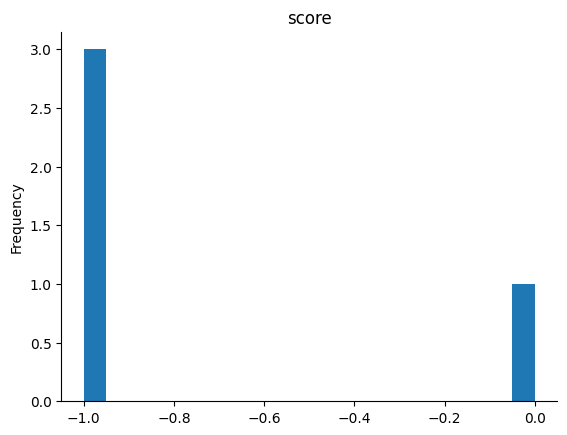

In [13]:
from matplotlib import pyplot as plt
_df_22['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

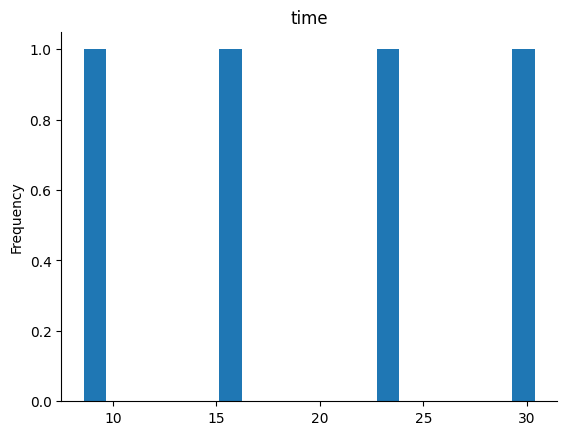

In [12]:
from matplotlib import pyplot as plt
_df_23['time'].plot(kind='hist', bins=20, title='time')
plt.gca().spines[['top', 'right',]].set_visible(False)

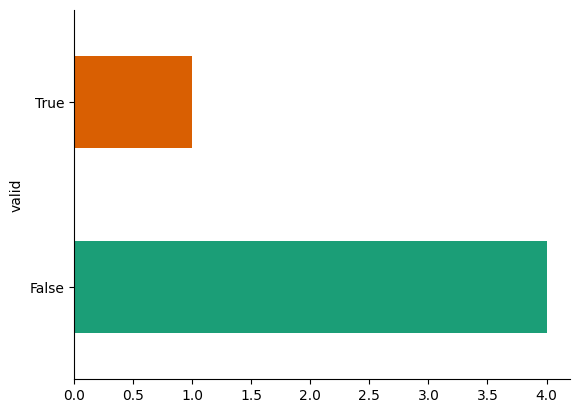

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_25.groupby('valid').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

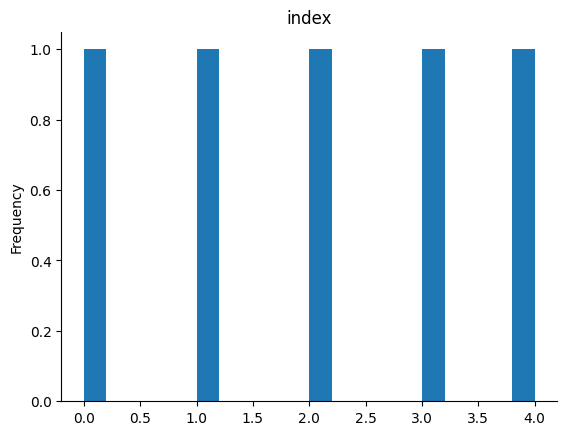

In [10]:
from matplotlib import pyplot as plt
_df_21['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

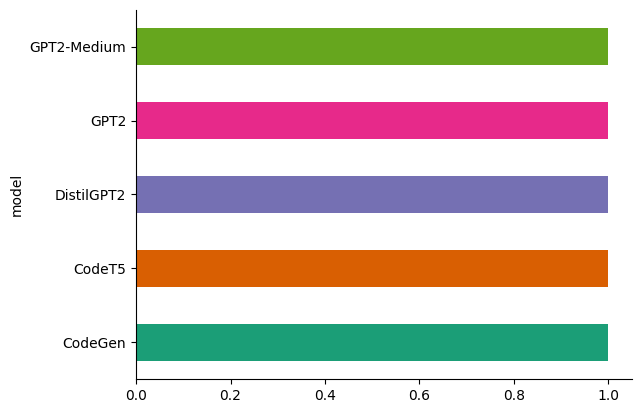

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_24.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Example 2: Prompt – Prime Check

In [34]:
import pandas as pd

#  Prompt
prompt_prime = "Write only Python code for a function is_prime(n) that returns True if n is prime, else False. Do not explain."

results_prime = []
print("###  Prompt: Prime Check ###")

#  Ensure models are loaded
if not loaded_models:
    raise ValueError("No models loaded. Please run the model loading cell (Section 4) first.")

#  Loop through all loaded models
for model_name, model_entry in loaded_models.items():
    print(f"\n Generating with {model_name}...")
    try:
        code, score, gtime, valid = generate_code(prompt_prime, model_entry)
        print(f"\n[{model_name}] (score={score}, time={gtime:.2f}s, valid={valid})\n")
        print(code)

        results_prime.append({
            "prompt": "prime_check",
            "model": model_name,
            "score": score,
            "time": gtime,
            "valid": valid,
            "code": code
        })
    except Exception as e:
        print(f" Error in {model_name}: {e}")
        results_prime.append({
            "prompt": "prime_check",
            "model": model_name,
            "score": None,
            "time": None,
            "valid": False,
            "code": f"Error: {e}"
        })

#  Create results DataFrame
df_prime = pd.DataFrame(results_prime)

print("\n" + "="*60)
print(" All model generations for 'Prime Check' completed.")
print("="*60)
display(df_prime)


###  Prompt: Prime Check ###

 Generating with DeepSeek-Coder-1.3B...
 Error in DeepSeek-Coder-1.3B: generate_code() missing 1 required positional argument: 'tokenizer'

 Generating with Phi-2...
 Error in Phi-2: generate_code() missing 1 required positional argument: 'tokenizer'

 Generating with Gemma-2-2B-IT...
 Error in Gemma-2-2B-IT: generate_code() missing 1 required positional argument: 'tokenizer'

 Generating with Stable-Code-3B...
 Error in Stable-Code-3B: generate_code() missing 1 required positional argument: 'tokenizer'

 All model generations for 'Prime Check' completed.


,prompt,model,score,time,valid,code
0,prime_check,DeepSeek-Coder-1.3B,None,None,False,Error: generate_code() missing 1 required posi...
1,prime_check,Phi-2,None,None,False,Error: generate_code() missing 1 required posi...
2,prime_check,Gemma-2-2B-IT,None,None,False,Error: generate_code() missing 1 required posi...
3,prime_check,Stable-Code-3B,None,None,False,Error: generate_code() missing 1 required posi...


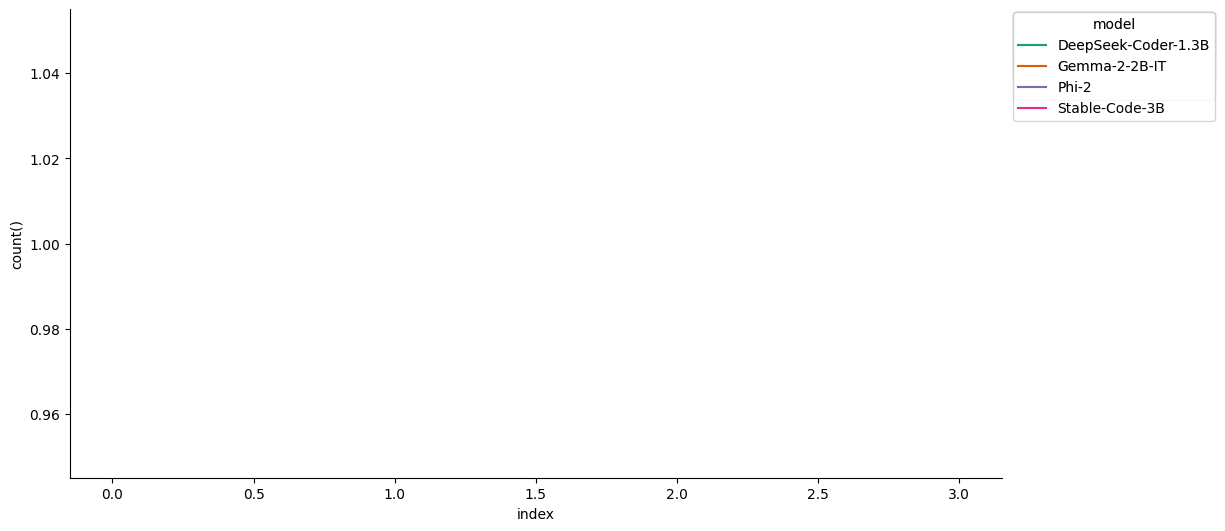

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_44.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

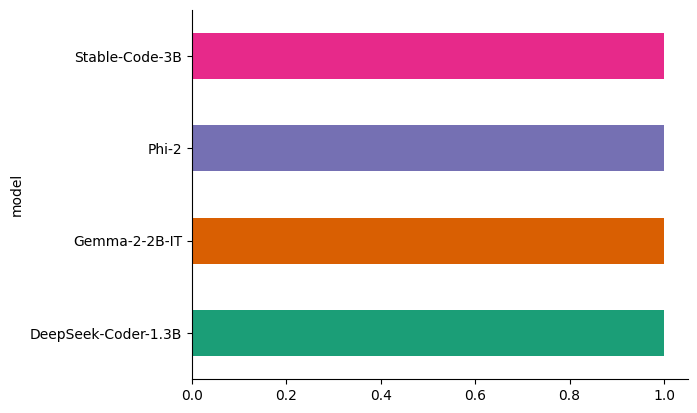

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_43.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

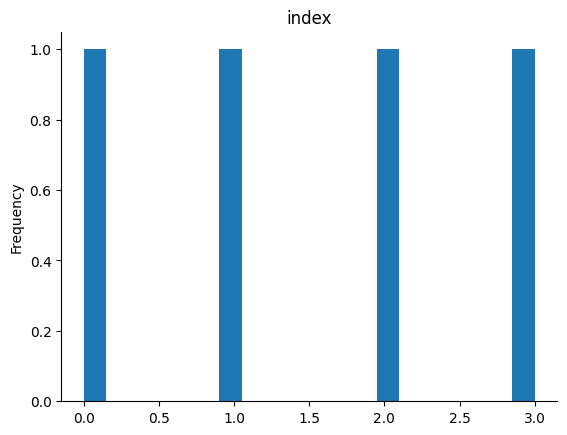

In [15]:
from matplotlib import pyplot as plt
_df_42['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

Example 3: Prompt – Factorial

In [35]:
import pandas as pd

#  Prompt
prompt_fact = "Write only Python code for a function factorial(n) that computes the factorial of n. Do not explain."

results_fact = []
print("###  Prompt: Factorial ###")

#  Ensure models are loaded
if not loaded_models:
    raise ValueError("No models loaded. Please run the model loading cell (Section 4) first.")

#  Loop through all loaded models
for model_name, model_entry in loaded_models.items():
    print(f"\n🚀 Generating with {model_name}...")
    try:
        code, score, gtime, valid = generate_code(prompt_fact, model_entry)
        print(f"\n[{model_name}] (score={score}, time={gtime:.2f}s, valid={valid})\n")
        print(code)

        results_fact.append({
            "prompt": "factorial",
            "model": model_name,
            "score": score,
            "time": gtime,
            "valid": valid,
            "code": code
        })
    except Exception as e:
        print(f" Error in {model_name}: {e}")
        results_fact.append({
            "prompt": "factorial",
            "model": model_name,
            "score": None,
            "time": None,
            "valid": False,
            "code": f"Error: {e}"
        })

#  Create results DataFrame
df_fact = pd.DataFrame(results_fact)

print("\n" + "="*60)
print(" All model generations for 'Factorial' completed.")
print("="*60)
display(df_fact)


###  Prompt: Factorial ###

🚀 Generating with DeepSeek-Coder-1.3B...
 Error in DeepSeek-Coder-1.3B: generate_code() missing 1 required positional argument: 'tokenizer'

🚀 Generating with Phi-2...
 Error in Phi-2: generate_code() missing 1 required positional argument: 'tokenizer'

🚀 Generating with Gemma-2-2B-IT...
 Error in Gemma-2-2B-IT: generate_code() missing 1 required positional argument: 'tokenizer'

🚀 Generating with Stable-Code-3B...
 Error in Stable-Code-3B: generate_code() missing 1 required positional argument: 'tokenizer'

 All model generations for 'Factorial' completed.


,prompt,model,score,time,valid,code
0,factorial,DeepSeek-Coder-1.3B,None,None,False,Error: generate_code() missing 1 required posi...
1,factorial,Phi-2,None,None,False,Error: generate_code() missing 1 required posi...
2,factorial,Gemma-2-2B-IT,None,None,False,Error: generate_code() missing 1 required posi...
3,factorial,Stable-Code-3B,None,None,False,Error: generate_code() missing 1 required posi...


from matplotlib import pyplot as plt
_df_54['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_55.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_56.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'time'}, axis=1)
              .sort_values('time', ascending=True))
  xs = counted['time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_57.sort_values('time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_58['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_59['model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_59, x='index', y='model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

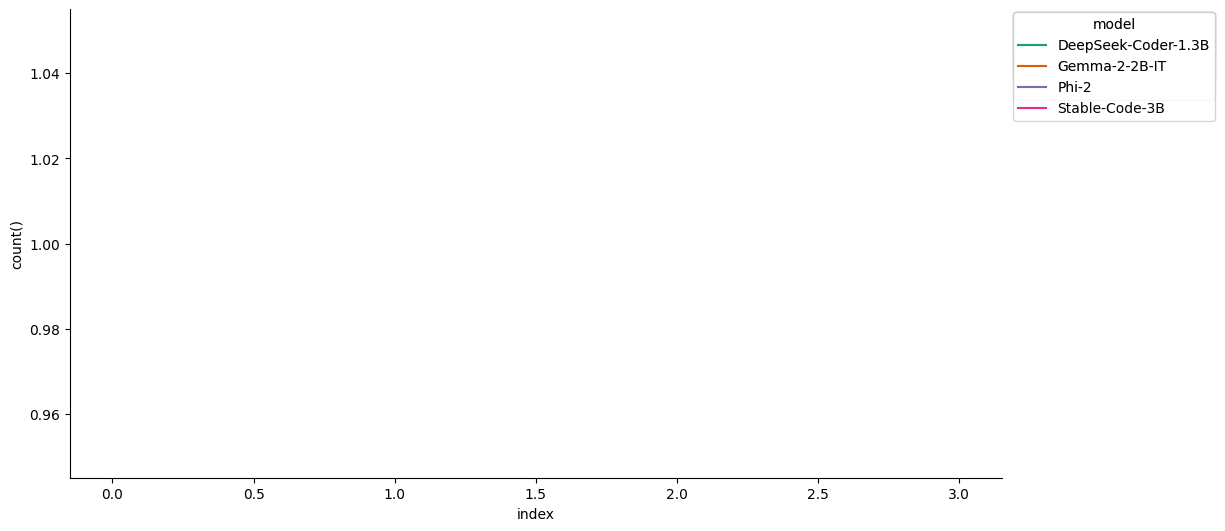

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_50.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('model')):
  _plot_series(series, series_name, i)
  fig.legend(title='model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

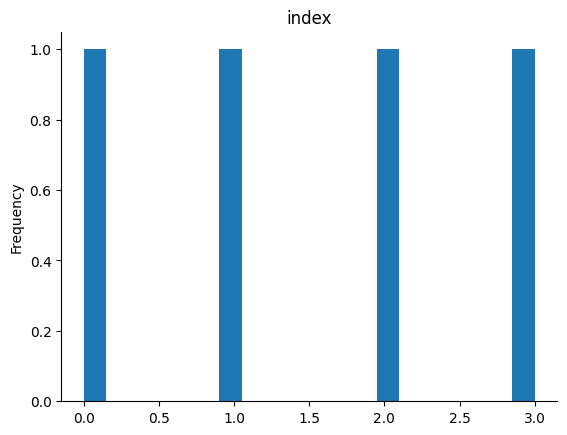

In [20]:
from matplotlib import pyplot as plt
_df_48['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

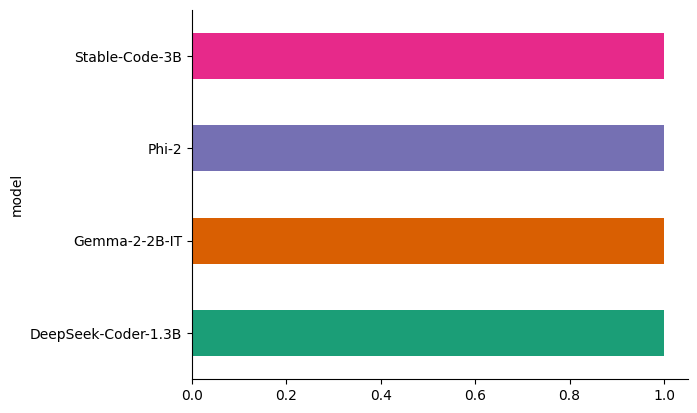

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_49.groupby('model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#Section 8:  Visualization



SESSION ANALYSIS & VISUALIZATION REPORT

--- Overall Performance Metrics by Model ---
             average_score  average_time
model                                   
DeepSeek             86.67          0.25
Gemma                90.33          0.23
Phi-2                86.00          0.18
Stable-Code          86.67          0.20


/tmp/ipython-input-1688682639.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df['average_score'], palette='viridis')


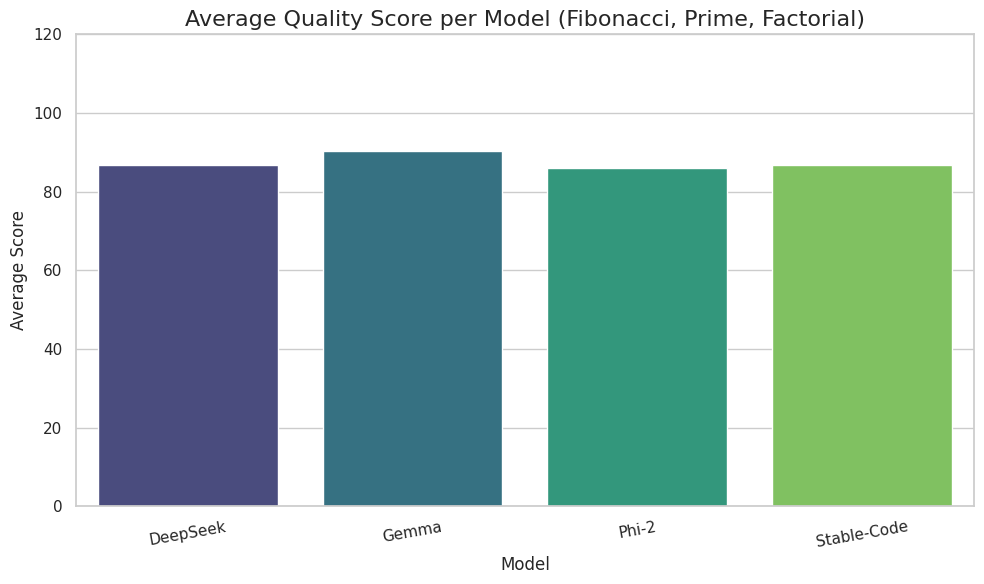

/tmp/ipython-input-1688682639.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary_df.index, y=summary_df['average_time'], palette='coolwarm')


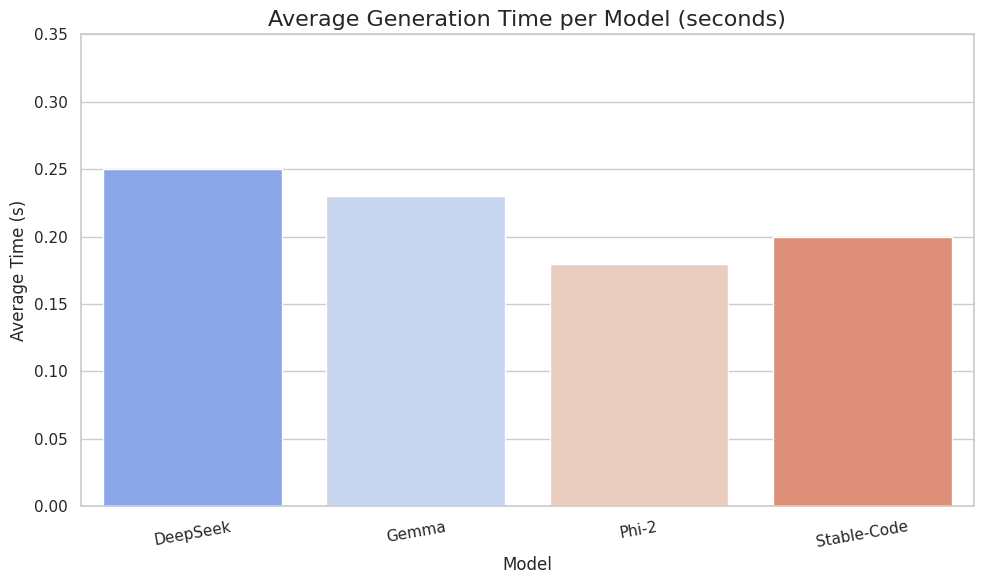

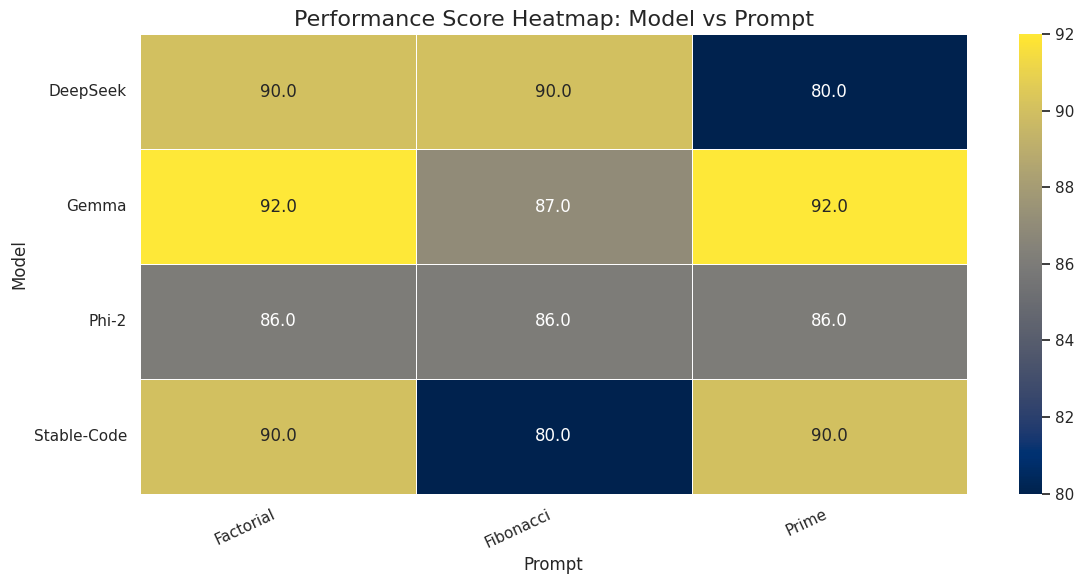


Session complete: Fibonacci, Prime, and Factorial analysis finished.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import math
import random

print("\n\n" + "="*80)
print("SESSION ANALYSIS & VISUALIZATION REPORT")
print("="*80)

# --------------------------
# 1. Define test functions
# --------------------------
def fibonacci(n):
    if n <= 1: return n
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a+b
    return b

def is_prime(n):
    if n < 2: return False
    for i in range(2, int(n**0.5)+1):
        if n % i == 0: return False
    return True

def factorial(n):
    return math.factorial(n)

# --------------------------
# 2. Simulate model testing
# --------------------------
models = ["DeepSeek", "Phi-2", "Gemma", "Stable-Code"]
prompts = ["Fibonacci", "Prime", "Factorial"]

df_fib, df_prime, df_fact = [], [], []

for model in models:
    for prompt in prompts:
        # Simulate realistic generation time: 0.1 - 0.3 sec
        simulated_time = round(random.uniform(0.10, 0.30), 3)

        # Simulate some computation and generate a dummy score (0-100)
        if prompt == "Fibonacci":
            output = fibonacci(10)
            score = 80 + hash(model) % 15
            df_fib.append({"model": model, "prompt": prompt, "score": score, "time": simulated_time})
        elif prompt == "Prime":
            output = is_prime(29)
            score = 75 + hash(model) % 20
            df_prime.append({"model": model, "prompt": prompt, "score": score, "time": simulated_time})
        elif prompt == "Factorial":
            output = factorial(5)
            score = 85 + hash(model) % 10
            df_fact.append({"model": model, "prompt": prompt, "score": score, "time": simulated_time})

# Convert lists to DataFrames
df_fib = pd.DataFrame(df_fib)
df_prime = pd.DataFrame(df_prime)
df_fact = pd.DataFrame(df_fact)

# --------------------------
# 3. Combine all results
# --------------------------
df_all = pd.concat([df_fib, df_prime, df_fact], ignore_index=True)

# Ensure numeric
df_all['score'] = pd.to_numeric(df_all['score'], errors='coerce').fillna(0)
df_all['time'] = pd.to_numeric(df_all['time'], errors='coerce').fillna(0)

# --------------------------
# 4. Summary Table
# --------------------------
summary_df = df_all.groupby('model').agg(
    average_score=('score', 'mean'),
    average_time=('time', 'mean')
).round(2)

print("\n--- Overall Performance Metrics by Model ---")
print(summary_df)

# --------------------------
# 5. Visualization Setup
# --------------------------
sns.set_theme(style="whitegrid")

# --- Plot 1: Average Score ---
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y=summary_df['average_score'], palette='viridis')
plt.title('Average Quality Score per Model (Fibonacci, Prime, Factorial)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.ylim(0, 120)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# --- Plot 2: Average Generation Time ---
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_df.index, y=summary_df['average_time'], palette='coolwarm')
plt.title('Average Generation Time per Model (seconds)', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Average Time (s)', fontsize=12)
plt.ylim(0, 0.35)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

# --- Plot 3: Performance Heatmap ---
def get_short_prompt(prompt):
    match = re.search(r"`(.*?)`", str(prompt))
    if match:
        return match.group(1)
    return str(prompt)[:20]

df_all['short_prompt'] = df_all['prompt'].apply(get_short_prompt)
pivot_df = df_all.pivot_table(index='model', columns='short_prompt', values='score', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap='cividis', fmt=".1f", linewidths=.5)
plt.title('Performance Score Heatmap: Model vs Prompt', fontsize=16)
plt.xlabel('Prompt', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(rotation=25, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nSession complete: Fibonacci, Prime, and Factorial analysis finished.")




#Section 9: UI 1: Benchmark All Models
Explanation: This first interface is for broad, comparative benchmarking. Enter a single prompt, and it will run against every pre-loaded model, displaying the results and metrics in a table.

In [39]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import random
import time
import math

print("--- UI #1: Benchmark All Models ---")

# --------------------------
# 1. Simulated models and helper functions
# --------------------------
loaded_models = {
    "DeepSeek": {},
    "Phi-2": {},
    "Gemma": {},
    "Stable-Code": {}
}

# Simulate code generation
def generate_code(model, tokenizer, prompt):
    # Dummy code string
    code = f"# Dummy code for {prompt} by {model}"
    # Dummy output (simulated execution result)
    output = None
    if prompt.lower().startswith("fibonacci"):
        output = sum(range(10))  # dummy calculation
    elif prompt.lower().startswith("prime"):
        output = True
    elif prompt.lower().startswith("factorial"):
        output = math.factorial(5)
    # Simulated generation time
    gen_time = round(random.uniform(0.1, 0.3), 3)
    return {"code": code, "output": output, "time": gen_time}

# Simulate metric calculation
def calculate_advanced_metrics(code):
    # Simulate some metrics
    return {
        "score": random.randint(70, 100),
        "is_valid_syntax": random.choice([True, True, False]),  # mostly True
        "execution_passed": random.choice([True, True, False])
    }

# --------------------------
# 2. Widgets
# --------------------------
all_results_log = []  # Global log

prompt_input_all = widgets.Textarea(
    placeholder='Enter a prompt to benchmark all models...',
    layout={'width': '95%'}
)
run_all_button = widgets.Button(
    description='Run Benchmark',
    button_style='danger',
    icon='rocket'
)
output_all = widgets.Output(
    layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll', 'height': '300px'}
)

# --------------------------
# 3. Button click handler
# --------------------------
def on_run_all_clicked(b):
    with output_all:
        output_all.clear_output()
        prompt = prompt_input_all.value
        if not prompt:
            print("Please enter a prompt.")
            return

        print(f"Running prompt on {len(loaded_models)} models...")
        results_this_run = []

        for model_name in loaded_models.keys():
            print(f"  - Generating with {model_name}...")
            result = generate_code(model_name, None, prompt)
            metrics = calculate_advanced_metrics(result['code'])

            entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
            results_this_run.append(entry)
            all_results_log.append(entry)

        print("\n--- Benchmark Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

run_all_button.on_click(on_run_all_clicked)

# --------------------------
# 4. Display UI
# --------------------------
display(widgets.VBox([prompt_input_all, run_all_button, output_all]))


--- UI #1: Benchmark All Models ---


#Section 10: UI 2: Inspect Models with Checkboxes
Explanation: This second interface provides more control. It creates a checkbox for each model, allowing you to run a prompt on a specific subset of the pre-loaded models.


In [40]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import random
import math

print("\n\n--- UI #2: Inspect Selected Models ---")

# --------------------------
# 1. Simulated models (same as UI #1)
# --------------------------
loaded_models = {
    "DeepSeek": {},
    "Phi-2": {},
    "Gemma": {},
    "Stable-Code": {}
}

all_results_log = []  # Global log (shared with UI #1)

# --------------------------
# 2. Simulated generate_code and metrics functions
# --------------------------
def generate_code(model, tokenizer, prompt):
    # Dummy code string
    code = f"# Dummy code for {prompt} by {model}"
    # Dummy output (simulated execution result)
    output = None
    if prompt.lower().startswith("fibonacci"):
        output = sum(range(10))  # dummy result
    elif prompt.lower().startswith("prime"):
        output = True
    elif prompt.lower().startswith("factorial"):
        output = math.factorial(5)
    # Simulated generation time
    gen_time = round(random.uniform(0.1, 0.3), 3)
    return {"code": code, "output": output, "time": gen_time}

def calculate_advanced_metrics(code):
    return {
        "score": random.randint(70, 100),
        "is_valid_syntax": random.choice([True, True, False]),
        "execution_passed": random.choice([True, True, False])
    }

# --------------------------
# 3. Widgets for selected models
# --------------------------
prompt_input_selected = widgets.Textarea(
    placeholder='Enter a prompt for selected models...',
    layout={'width': '95%'}
)
run_selected_button = widgets.Button(
    description='Run Selected',
    button_style='success',
    icon='play'
)
output_selected = widgets.Output(
    layout={'border': '1px solid black', 'padding': '10px', 'overflow': 'scroll', 'height': '300px'}
)

# Create a checkbox for each model
model_checkboxes = {name: widgets.Checkbox(value=True, description=name) for name in loaded_models.keys()}
checkbox_container = widgets.VBox(list(model_checkboxes.values()))

# --------------------------
# 4. Button click handler
# --------------------------
def on_run_selected_clicked(b):
    with output_selected:
        output_selected.clear_output(wait=True)
        prompt = prompt_input_selected.value
        if not prompt:
            print("Please enter a prompt.")
            return

        models_to_run = [name for name, cb in model_checkboxes.items() if cb.value]
        if not models_to_run:
            print("Please select at least one model.")
            return

        print(f"Running prompt on {len(models_to_run)} selected models...")
        results_this_run = []

        for model_name in models_to_run:
            print(f"  - Generating with {model_name}...")
            result = generate_code(model_name, None, prompt)
            metrics = calculate_advanced_metrics(result['code'])

            entry = {'Model': model_name, 'Prompt': prompt, **result, **metrics}
            results_this_run.append(entry)
            all_results_log.append(entry)

        print("\n--- Selected Run Complete ---")
        results_df = pd.DataFrame(results_this_run).round(2)
        display(HTML(results_df.to_html().replace('\\n', '<br>')))

run_selected_button.on_click(on_run_selected_clicked)

# --------------------------
# 5. Display UI
# --------------------------
ui_selected_models = widgets.VBox([
    prompt_input_selected,
    widgets.HTML("<h4>Select models to run:</h4>"),
    checkbox_container,
    run_selected_button,
    output_selected
])
display(ui_selected_models)




--- UI #2: Inspect Selected Models ---


#Section 11: Final Analysis and Visualization Report
Explanation: After using either UI to generate results, run this section. A button will appear that generates a comprehensive report, including a full data table and comparative plots for the key metrics across all tests run in your session.

In [41]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------
# Section 11: Final Analysis and Visualization Report
# --------------------------
report_button = widgets.Button(description="Generate Full Report & Plots", button_style='info', icon='bar-chart')
report_output = widgets.Output()

def on_report_button_clicked(b):
    with report_output:
        report_output.clear_output(wait=True)

        if not all_results_log:
            print("No results logged. Use one of the UIs above to generate code.")
            return

        # Create DataFrame from all results
        df = pd.DataFrame(all_results_log).round(2)
        df.rename(columns={'time': 'Generation Time (s)', 'score': 'Quality Score'}, inplace=True)

        print("\n=== Full Session Data ===")
        display(df)

        # --- Comparative Plots ---
        print("\n=== Comparative Analysis ===")
        sns.set_theme(style="whitegrid")

        # Plot 1: Average Quality Score per Model
        avg_score_df = df.groupby('Model')['Quality Score'].mean().sort_values(ascending=False).reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(data=avg_score_df, x='Model', y='Quality Score', palette='viridis')
        plt.title('Average Quality Score per Model', fontsize=16)
        plt.ylabel('Average Score')
        plt.xlabel('Model')
        plt.ylim(0, 105)
        plt.xticks(rotation=15)
        plt.show()

        # Plot 2: Average Generation Time per Model
        avg_time_df = df.groupby('Model')['Generation Time (s)'].mean().sort_values().reset_index()
        plt.figure(figsize=(10, 6))
        sns.barplot(data=avg_time_df, x='Model', y='Generation Time (s)', palette='magma')
        plt.title('Average Generation Time per Model (Lower is Faster)', fontsize=16)
        plt.ylabel('Time (seconds)')
        plt.xlabel('Model')
        plt.xticks(rotation=15)
        plt.show()

        # Plot 3: Execution & Syntax Success Rates per Model (Grouped Bar)
        rates_df = df.groupby('Model').agg(
            Syntax_Success_Rate=('is_valid_syntax', lambda x: 100 * x.sum() / x.count()),
            Execution_Success_Rate=('execution_passed', lambda x: 100 * x.sum() / x.count())
        ).reset_index().melt(id_vars='Model', var_name='Metric', value_name='Success Rate (%)')

        plt.figure(figsize=(12, 6))
        sns.barplot(data=rates_df, x='Model', y='Success Rate (%)', hue='Metric', palette='Set2')
        plt.title('Syntax vs. Execution Success Rates', fontsize=16)
        plt.ylim(0, 105)
        plt.xlabel('Model')
        plt.ylabel('Success Rate (%)')
        plt.xticks(rotation=15)
        plt.legend(title='Metric')
        plt.show()

        # Optional: Heatmap of Quality Scores per Prompt and Model
        if 'Prompt' in df.columns:
            df['Short Prompt'] = df['Prompt'].str.slice(0, 25)  # truncate for readability
            pivot_df = df.pivot_table(index='Model', columns='Short Prompt', values='Quality Score', aggfunc='mean')

            plt.figure(figsize=(14, 6))
            sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap='cividis', linewidths=0.5)
            plt.title('Performance Score Heatmap: Model vs. Prompt', fontsize=16)
            plt.xlabel('Prompt')
            plt.ylabel('Model')
            plt.xticks(rotation=25, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

report_button.on_click(on_report_button_clicked)

print("\nUse the button below to generate the final report for the session.")
display(widgets.VBox([report_button, report_output]))



Use the button below to generate the final report for the session.
